# MonteCarlo Learning Introduction.

---

I highly recommend to visit the David Silver Lectures on Monte-Carlo Reinforcement Learning: https://www.youtube.com/watch?v=PnHCvfgC_ZA&t

In contrast of **Dynamic Programming**, **MonteCarlo Learning** methods learn directly from episodes of experience. These methods are model-free, which means they don't need knowledge about the MDP probability transitions / reward functions. MC learns from complete episodes (no bootstrapping). It uses the simplest possible idea: the value of a state is equal to its mean return. 

In this notebook, we first consider the problem of the policy evaluation using montecarlo learning, then, we continue with policy control. To present both algorithms, we solve again the GridWorld problem using a **policy and environment deterministic approach**, as explained in the Dynamic Programming Introduction section.

<img src = "./imagenes/montecarlo_backup.png" width = "500" height = "200" >

### 1. Policy Evaluation (Prediction) for Montecarlo Learning.

---
1. Goal: Learn $V_{\pi}$ from episodes of experience under the policy $\pi$, i.e, $S_{1}, A_{1}, R_{2}, ..., S_{k}$ following policy $\pi$.

2. Recall that the return is the total discounted reward:
$Gt = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1} R_{T}$

3. Recall that the value function is the expected return: 
$V_{\pi}(s) = E_{\pi}[G_{t} | S_{t} = s]$

4. Monte-Carlo policy evalation uses empirical mean return instead of expected return.

In this sub-section, we will use the same example used in Dynamic Programming Lecture to introduce the policy evaluation algorithm.

<img src = "./imagenes/monte_carlo_policy_evaluation_algorithm.png" width = "600px" height="400px">

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [2]:
class Graphics():
    
    def __init__(self):
        print("Graphics module ready!")
        
    def render(self, x, y, policy_evaluator, plot_values = True):
            
        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

         # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.2, 0.8), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))
        
        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))
        
        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(x, y, s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(policy_evaluator.value_state_table)):
                for j in range(0, len(policy_evaluator.value_state_table[0])):
                    plt.text(self.environment.grid_pos[i] - 0.08, self.environment.grid_pos[j] - 0.03, 
                             round(policy_evaluator.value_state_table[i][j], 1), fontsize=10)
                
        # Plot grid.
        plt.axis("off")
        plt.show()  

In [3]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw]]
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]

In [4]:
class modelFreeAgent():
    
    def __init__(self, policy, discount_factor):
        self.pos = [0,0]
        self.total_reward = 0
        self.discount_factor = discount_factor
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Move!
    def move(self, environment):
    
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        if action == "r":
            action = self.actions[random.randint(0, 3)]

        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action, environment)
        
    # Select action according to policy.
    def selectAction(self, state):
        
        if(self.policy[state[0]][state[1]] == "r"):
            action = self.actions[random.randint(0, len(self.available_actions) - 1)] # Agent initial policy.
        else: 
            action = self.policy[state[0]][state[1]]
        return action
            
    def forwardState(self, pos, action, environment):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]
        elif(action == "down" and pos[1] > 0):
            if(environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]
        elif(action == "right" and pos[0] < 4):
            if(environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position

    def getPosition(self):
        return self.pos
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]
        
    def selectBestAction(self, value_state_table, environment):
        
        go_up = self.forwardState(self.pos, "up", environment)
        go_down = self.forwardState(self.pos, "down", environment)
        go_left = self.forwardState(self.pos, "left", environment)
        go_right = self.forwardState(self.pos, "right", environment)
        
        up_value = value_state_table[go_up[0]][go_up[1]]
        down_value = value_state_table[go_down[0]][go_down[1]]
        left_value = value_state_table[go_left[0]][go_left[1]]
        right_value = value_state_table[go_right[0]][go_right[1]]
        values = [up_value, down_value, left_value, right_value]
        
        best_action = self.actions[values.index(max(values))] 
        return best_action       

In [5]:
class PolicyEvaluation(Graphics):
    
    def __init__(self, environment, agent, ephocs = 10, visit = "first"):
        
        self.environment = environment       
        self.agent = agent                     
        self.ephocs = ephocs
        self.value_state_table = [[0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 100, 0]]
        self.visit = visit
        
        # Generate a list for each state.
        self.states_list = list()
        for i in range(0, 5):
            column = list()
            for j in range(0, 5):
                column.append(list())
            self.states_list.append(column)
    
    def evaluate(self, plot_grid = True):
        self.montecarlo_policy_evaluation(self.ephocs, plot_grid)
        
    def montecarlo_policy_evaluation(self, ephocs, plot_grid):
        
        # Set agent position.
        self.agent.setPosition(0, 0)
        
        # Initialize list of states & rewards.
        list_of_states = list()
        list_of_rewards = list()
        
        # Append current position.
        list_of_states.append([0, 0])
        
        for k in range(0, ephocs):
            while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
                
                # Move the player.
                self.agent.move(self.environment)
                
                # Append new position
                list_of_states.append(self.agent.pos)
                list_of_rewards.append(self.environment.rewards[self.agent.pos[0]][self.agent.pos[1]])

                # Method of the super class.
                if(plot_grid):

                    # Render game.
                    pos = self.agent.getPosition()
                    grid_coords = self.environment.grid_pos

                    self.render(self.environment.grid_pos[pos[0]], self.environment.grid_pos[pos[1]], self, True)
                    time.sleep(0.1)
                    clear_output(wait = True)
                    
            # Update Value State Table with MonteCarlo algorithm.
            if self.visit == "first":
                self.updateValueStateTable_MC_FirstVisit(list_of_states, list_of_rewards)
            elif self.visit == "multiple":
                self.updateValueStateTable_MC_MultipleVisits(list_of_states, list_of_rewards)
            
            # Set players position at the beginning.
            self.agent.setPosition(0, 0)
            
            # Reset lists.
            list_of_states = list()
            list_of_rewards = list()
            list_of_states.append([0, 0])
                    
    def updateValueStateTable_MC_FirstVisit(self, list_of_states, list_of_rewards):
            
        # Initialize discount reward factor. 
        G = 0
        
        # Execute montecarlo learning algorithm.
        for s in range(0, len(list_of_states) - 1):

            # Update cumulative discount return.
            G += self.agent.discount_factor * list_of_rewards[len(list_of_states) - 2 - s]

            # Check if current state is not in the list.
            not_in_list = True
            current_state = list_of_states[len(list_of_states) - 2 - s]
            states_copy = list_of_states[0: len(list_of_states) - 3 - s].copy()

            #print(states_copy)
            
            for st in states_copy:
                if current_state == st:
                    not_in_list = False
                
            # Update state value table.
            if (not_in_list) and current_state != [4, 3]:
                
                # Compute new state value.
                array = self.states_list[current_state[0]][current_state[1]]
                array.append(G)
                average = self.getAverage(array)
                self.value_state_table[current_state[0]][current_state[1]] = average
                
                # Render value state update.
                if False:
                    self.agent.setPosition(current_state[0], current_state[1])
                    pos = self.agent.getPosition()
                    self.render(self.environment.grid_pos[pos[0]], self.environment.grid_pos[pos[1]], self, True)
                    time.sleep(0.1)
                    clear_output(wait = True)

    def updateValueStateTable_MC_MultipleVisits(self, list_of_states, list_of_rewards):
            
        # Initialize discount reward factor. 
        G = 0
        
        # Execute montecarlo learning algorithm.
        for s in range(0, len(list_of_states) - 1):

            # Update cumulative discount return.
            G += self.agent.discount_factor * list_of_rewards[len(list_of_states) - 2 - s]
            current_state = list_of_states[len(list_of_states) - 2 - s]

            # Update state value table.
            if current_state != [4, 3]:
                
                # Compute new state value.
                array = self.states_list[current_state[0]][current_state[1]]
                array.append(G)
                average = self.getAverage(array)
                self.value_state_table[current_state[0]][current_state[1]] = average
                
                # Render value state update.
                if False: 
                    self.agent.setPosition(current_state[0], current_state[1])
                    pos = self.agent.getPosition()
                    self.render(self.environment.grid_pos[pos[0]], self.environment.grid_pos[pos[1]], self, True)
                    time.sleep(0.05)
                    clear_output(wait = True)
                
                
    def getAverage(self, array):
        average = 0
        for num in array: 
            average += num
        return average / len(array)
    
    def updatePolicy(self):
         for i in range(0, len(self.value_state_table)):
                for j in range(0, len(self.value_state_table[0])):
                    if self.environment.walls_and_paths[i][j] == 1:
                        # Set agent position.
                        self.agent.setPosition(i, j)
                        best_action = self.agent.selectBestAction(self.value_state_table, self.environment)
                        self.agent.policy[i][j] = best_action

In [6]:
class Game(Graphics):
    
    def __init__(self, environment, agent):
        
        self.environment = environment       
        self.agent = agent             
        
    def update(self, secs):
        
        pos = self.agent.getPosition()
        grid_coords = self.environment.grid_pos
        self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
        time.sleep(1)
        clear_output(wait = True)
        
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
            
            self.agent.move(self.environment)
            pos = self.agent.getPosition()
            self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
            
            time.sleep(secs)
            clear_output(wait = True)
            
        #self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
        #time.sleep(secs)
        #print("Yuhuu, we won the game!")
        #clear_output(wait = True)

#### 1.1 Policy Evaluation - Montecarlo Learning First Visit.

In [7]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)

# Initialize environment and agent.
discount_factor = 0.9
environment = GridEnvironment()
agent = modelFreeAgent(policy, discount_factor)

# Initialize policy evaluation class.
ephocs = 2000
policy_evaluation = PolicyEvaluation(environment, agent, ephocs, visit = "first")
policy_evaluation.evaluate(plot_grid = False)
policy_evaluation.updatePolicy()

#### Win the Game with the previous policy evaluation results.

In [8]:
agent.policy

[['up', 'right', 'down', 'down', 'down'],
 ['r', 'right', 'r', 'r', 'left'],
 ['up', 'up', 'up', 'right', 'r'],
 ['left', 'r', 'up', 'right', 'right'],
 ['left', 'down', 'r', 'down', 'down']]

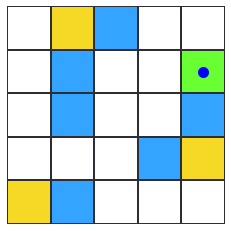

In [9]:
agent.pos = [1,4]
game = Game(environment, agent)
game.update(secs = 0.5)

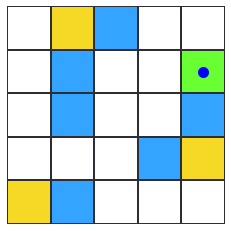

In [10]:
agent.pos = [4, 1]
game = Game(environment, agent)
game.update(secs = 0.5)

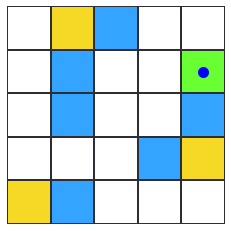

In [12]:
agent.pos = [0, 0]
game = Game(environment, agent)
game.update(secs = 0.5)

#### 1.2  Policy Evaluation - Montecarlo Learning Multiple Visits.

In [13]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)

# Initialize environment and agent.
discount_factor = 0.9
environment2 = GridEnvironment()
agent2 = modelFreeAgent(policy, discount_factor)

# Initialize policy evaluation class.
ephocs = 1000
policy_evaluation = PolicyEvaluation(environment2, agent2, ephocs, visit = "multiple")
policy_evaluation.evaluate(plot_grid = False)
policy_evaluation.updatePolicy()

#### Win the Game with the previous policy evaluation results.

In [14]:
agent.policy

[['up', 'right', 'down', 'down', 'down'],
 ['r', 'right', 'r', 'r', 'left'],
 ['up', 'up', 'up', 'right', 'r'],
 ['left', 'r', 'up', 'right', 'right'],
 ['left', 'down', 'r', 'down', 'down']]

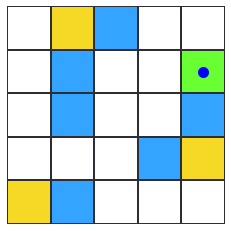

In [18]:
agent.pos = [4,1]
game = Game(environment, agent)
game.update(secs = 0.5)

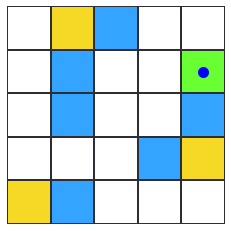

In [16]:
agent.pos = [1, 4]
game = Game(environment, agent)
game.update(secs = 0.5)

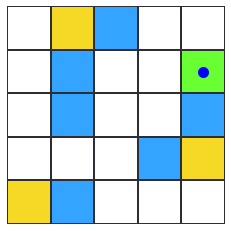

In [17]:
agent.pos = [0, 0]
game = Game(environment, agent)
game.update(secs = 0.5)

### 2. Policy Improvement (Control) for MonteCarlo Learning
##### Also know as Greedy in the Limit with Infinite Exploration (GLIE).

In the preceding section, we evaluated a given policy (the random policy) using montecarlo learning (remember, we don't have absolute knowledge about de MDP model). But, what about the policy improvement? Should we use the same method employed in the Dynamic Programming section? **Of course not.** As we already mentioned, MonteCarlo learning method learns from episodes of experience. This episodes are built by sampling, which means that if we use the same method proposed in the Dynamic Programming section to improve the agent policy, there is not guarentee that we will be able to properly evaluate the value of all the environment states. Furthermore, we can't compute the best action value based on the modelling used in the Dynamic Programming section because we don't have information about the transition probabilities between two states nor the reward function.

Hence, we will use another approach to perform policy improvement using MonteCarlo Learning:

1. MonteCarlo Policy Evaluation, $Q = q_{\pi}$
2. MonteCarlo Policy Improvement, $\epsilon$-greedy policy.

<img src="./imagenes/montecarlo_control_preview_algorithm.png" width = "600px">

---

<img src="./imagenes/montecarlo_control_egreedy_algorithm.png" width = "600px">


In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [2]:
class Graphics():
    
    def __init__(self):
        print("Graphics module ready!")
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
        
    def render(self, position, q_value_table, plot_values = True):
            
        fig1 = plt.figure(figsize=(7, 7))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

         # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))

        ax1.add_patch(patches.Rectangle((0.2, 0.8), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#F6D924"))

        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))

        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))

        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))

        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(self.grid_pos[position[0]], self.grid_pos[position[1]], s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(q_value_table)):
                for j in range(0, len(q_value_table)):
                    
                    colors = ["black", "black", "black", "black"]
                    fontsize_ = [11, 11, 11, 11]
                    
                    q_values = list()
                    for action in range(0, 4):
                        q_values.append(q_value_table[i][j][action])
                    if not q_values == [0, 0, 0 ,0]:
                        best_q = max(q_values)
                        best_q = q_values.index(best_q)
                        colors[best_q] = "blue"
                        fontsize_[best_q] = 13

                    # Up, bottom, left, right.
                    plt.text(i/5 + 0.075, j/5 + 0.15, int(q_value_table[i][j][0]), fontsize=fontsize_[0], c = colors[0])
                    plt.text(i/5 + 0.075, j/5 + 0.03, int(q_value_table[i][j][1]), fontsize=fontsize_[1], c = colors[1])
                    plt.text(i/5 + 0.01, j/5 + 0.085, int(q_value_table[i][j][2]), fontsize=fontsize_[2], c = colors[2])
                    plt.text(i/5 + 0.14, j/5 + 0.085, int(q_value_table[i][j][3]), fontsize=fontsize_[3], c = colors[3])

        # Plot grid.
        plt.axis("off")
        plt.show() 

In [3]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, 10, self.rw]]

In [4]:
class modelFreeAgent():
    
    def __init__(self, policy, discount_factor):
        self.pos = [0,0]
        self.total_reward = 0
        self.discount_factor = discount_factor
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Move!
    def move(self, action, environment):
        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action, environment)
        
    # Take an action!
    def takeAction(self, epsilon):
        
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        if action == "r":
            action = self.actions[random.randint(0, 3)]
        else:
            # Epsilon-greedy policy!
            num = random.randint(1, 100)
            if not num < (1 - epsilon + epsilon/len(self.actions)) * 100:
                action = self.actions[random.randint(0, 3)]
        return action
        
    # Get forward state.
    def forwardState(self, pos, action, environment):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]
        elif(action == "down" and pos[1] > 0):
            if(environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]
        elif(action == "right" and pos[0] < 4):
            if(environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position
    
    def getPosition(self):
        return self.pos.copy()
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]
        
    def selectBestAction(self, value_state_table, environment):
        
        go_up = self.forwardState(self.pos, "up", environment)
        go_down = self.forwardState(self.pos, "down", environment)
        go_left = self.forwardState(self.pos, "left", environment)
        go_right = self.forwardState(self.pos, "right", environment)
        
        up_value = value_state_table[go_up[0]][go_up[1]]
        down_value = value_state_table[go_down[0]][go_down[1]]
        left_value = value_state_table[go_left[0]][go_left[1]]
        right_value = value_state_table[go_right[0]][go_right[1]]
        values = [up_value, down_value, left_value, right_value]
        
        best_action = self.actions[values.index(max(values))] 
        return best_action       

In [5]:
class PolicyControl(Graphics):
    
    # Initialize policy control object.
    def __init__(self, environment, agent, epsilon = 0.2, ephocs = 10):
        
        # Initialize environment & agent.
        self.environment = environment       
        self.agent = agent               
        
        # Set ephocs and control method (visit: first or multiple).
        self.ephocs = ephocs
        self.graphics = Graphics()
        
        # Generate Q value table.
        self.q_value_table = list()
        for i in range(0, 5):
            column = list()
            for j in range(0, 5):
                column.append([0, 0, 0, 0])
            self.q_value_table.append(column)
       
        # Generate list for each state action.
        self.lists_state_action = list()
        for i in range(0, 5):
            column = list()
            for j in range(0, 5):
                column.append([list(), list(), list(), list()])
            self.lists_state_action.append(column)
                
    # Montecarlo control algorithm.
    def montecarlo_policy_control_first_visit(self, velocity = 0.05, plot_ephocs = True, plot_evaluation = True):

        # Evaluate k episodes.
        for k in range(0, self.ephocs):
            
            #print("epoch:", k)
            
            # Set epsilon.
            epsilon = 0.2 #float(1/ (k+1))

            # Generate a new episode.
            episode = self.generateEpisode(k, epsilon, velocity, plot_ephocs)

            # Get episode info.
            list_of_states_action = episode[0]
            list_of_rewards = episode[1]

            # Initialize discount reward factor. 
            G = 0

            # Execute montecarlo learning algorithm.
            for s in range(0, len(list_of_states_action) - 1):

                #print(list_of_states_action[len(list_of_states_action) - 1 - s])

                # Update cumulative discount return.
                G += self.agent.discount_factor * list_of_rewards[len(list_of_states_action) - 1 - s]

                # Check if current state action is not in the list.
                not_in_list = True

                current_state_action = list_of_states_action[len(list_of_states_action) - 1 - s]
                states_action_copy = list_of_states_action[0: len(list_of_states_action) - 2 - s].copy()

                for sta in states_action_copy:
                    if current_state_action == sta:
                        not_in_list = False

                # Update state value table.
                if (not_in_list) and current_state_action[0] != [4, 3]:

                    # Compute new state value.
                    x_index = current_state_action[0][0]
                    y_index = current_state_action[0][1]
                    z_index = self.agent.actions.index(current_state_action[1])

                    array = self.lists_state_action[x_index][y_index][z_index]
                    array.append(G)
                    average = self.getAverage(array)
                    self.q_value_table[x_index][y_index][z_index] = average

                    # Render Q-value update.
                    if plot_evaluation: 
                        self.agent.setPosition(x_index, y_index)
                        self.render()
                        time.sleep(velocity)
                        clear_output(wait = True)
                        
                    # Update e-greedy policy.
                    self.update_egreedy_policy(x_index, y_index)
                    
    # Montecarlo control algorithm.
    def montecarlo_policy_control_multiple_visits(self, velocity = 0.05, plot_ephocs = True, plot_evaluation = True):

        # Evaluate k episodes.
        for k in range(0, self.ephocs):
            
            #print("epoch:", k)
            
            # Set epsilon.
            epsilon = 0.2 # float(1/ (k+1))

            # Generate a new episode.
            episode = self.generateEpisode(k, epsilon, velocity, plot_ephocs)

            # Get episode info.
            list_of_states_action = episode[0]
            list_of_rewards = episode[1]

            # Initialize discount reward factor. 
            G = 0

            # Execute montecarlo learning algorithm.
            for s in range(0, len(list_of_states_action) - 1):

                #print(list_of_states_action[len(list_of_states_action) - 1 - s])

                # Update cumulative discount return.
                G += self.agent.discount_factor * list_of_rewards[len(list_of_states_action) - 1 - s]

                # Compute new state value.
                current_state_action = list_of_states_action[len(list_of_states_action) - 1 - s]
                x_index = current_state_action[0][0]
                y_index = current_state_action[0][1]
                z_index = self.agent.actions.index(current_state_action[1])

                array = self.lists_state_action[x_index][y_index][z_index]
                array.append(G)
                average = self.getAverage(array)
                self.q_value_table[x_index][y_index][z_index] = average

                # Render Q-value update.
                if plot_evaluation: 
                    self.agent.setPosition(x_index, y_index)
                    self.render()
                    time.sleep(velocity)
                    clear_output(wait = True)

                # Update e-greedy policy.
                self.update_egreedy_policy(x_index, y_index)
                    
    def generateEpisode(self, k, epsilon, velocity, plot_ephocs):
        
        # Initialize lists.
        states_action_list = list()
        reward_list = list()
        
        # Set agent position.
        positions = [(0,0), (1, 4), (4, 1)]
        initial_state = positions[k % 3]
        self.agent.setPosition(initial_state[0], initial_state[1])

        # While agent is not in the terminal state.
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
    
            # Take an action according to the agent policy adn save data.
            action = self.agent.takeAction(epsilon)
            states_action_list.append([self.agent.pos, action])
            action_new_pos = self.agent.forwardState(self.agent.pos, action, self.environment)
            reward_list.append(self.environment.rewards[action_new_pos[0]][action_new_pos[1]])
            
            # Render Q-value update.
            if plot_ephocs: 
                self.render()
                time.sleep(velocity)
                clear_output(wait = True)
                
            # Move agent.
            self.agent.move(action, self.environment)
            
        return [states_action_list, reward_list]
    
    def render(self):
        self.graphics.render(self.agent.pos, self.q_value_table)
    
    def getAverage(self, array):
        average = 0
        for num in array: 
            average += num
        return average / len(array)
    
    # Update egreedy policy.
    def update_egreedy_policy(self, x, y):
        q_values = list()
        for action in range(0, 4):
            q_values.append(self.q_value_table[x][y][action])
        if not q_values == [0, 0, 0, 0]:
            best_q = max(q_values)
            best_q = q_values.index(best_q)
            self.agent.policy[x][y] = self.agent.actions[best_q]

Graphics module ready!


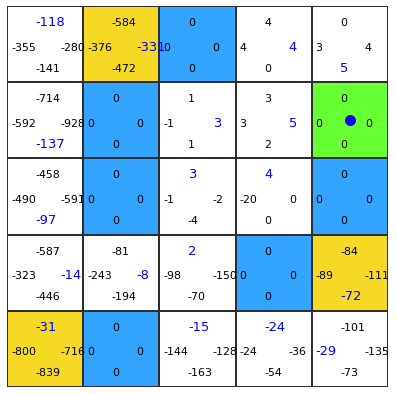

In [6]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)
discount_factor = 0.5

agent = modelFreeAgent(policy, discount_factor)
environment = GridEnvironment()

# MonteCarlo first visit.
policy_control = PolicyControl(environment, agent, epsilon = 0.2, ephocs = 100)
policy_control.montecarlo_policy_control_first_visit(velocity = 0.01, plot_ephocs = False, plot_evaluation = False)
policy_control.render()

In [7]:
agent.policy

[['up', 'right', 'down', 'down', 'up'],
 ['r', 'right', 'r', 'r', 'right'],
 ['up', 'up', 'up', 'right', 'r'],
 ['up', 'r', 'up', 'right', 'right'],
 ['left', 'down', 'r', 'r', 'down']]

Graphics module ready!


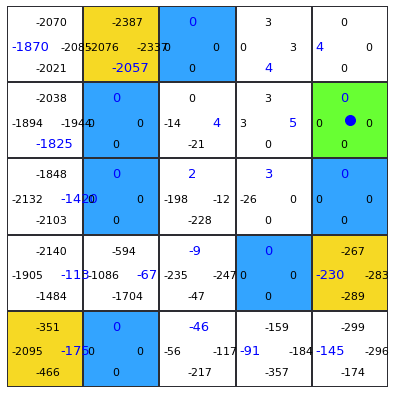

In [7]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)
discount_factor = 0.5

agent = modelFreeAgent(policy, discount_factor)
environment = GridEnvironment()

# MonteCarlo multiple visits.
policy_control = PolicyControl(environment, agent, epsilon = 0.2, ephocs = 100)
policy_control.montecarlo_policy_control_multiple_visits(velocity = 0.01, plot_ephocs = False, plot_evaluation = False)
policy_control.render()

In [9]:
agent.policy

[['right', 'right', 'right', 'down', 'left'],
 ['r', 'right', 'r', 'r', 'down'],
 ['up', 'up', 'up', 'right', 'r'],
 ['left', 'r', 'up', 'right', 'down'],
 ['left', 'left', 'r', 'r', 'left']]